In [20]:
# Import all the necessary packages
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import collections as mc

import sys
sys.path.append('..')
sys.path.append('../ark')

from ark.utils import spatial_analysis_utils, io_utils, load_utils # noqa: E402
from ark.analysis import spatial_analysis, visualize

import ark.settings as settings

In [21]:
# This script takes a cell expression matrix, label maps for the fovs to be included in the analysis, and, depending
# on the analysis, a threshold matrix for channel or cluster spatial analysis. In channel spatial analysis, cells for
# a specific fov are identified, and cells of particular phenotypes are compared to each other to check for positive,
# negative, or no enrichment. To do this, a distance matrix is created from the label_maps, cell phenotypes are
# identified by their labels in the image and then significant interactions between different populations of phenotypes
# are recorded. Similar analysis is also done for channel spatial enrichment; however, instead of looking at cell
# phenotypes, markers positive for specific thresholds are identified and specific interactions are then characterized
# between them.

In [24]:
# Set up file paths and import data
base_dir = "../data/Breast/Breast1"
input_dir = os.path.join(base_dir, "input_data")
tiff_dir = os.path.join(input_dir, "single_channel_inputs/")
deepcell_input_dir = os.path.join(input_dir, "deepcell_input/")
deepcell_output_dir = os.path.join(base_dir, 'deepcell_output')
single_cell_dir = os.path.join(base_dir, "single_cell_output")
viz_dir = os.path.join(base_dir, "deepcell_visualization")
spatial_analysis_dir = os.path.join(base_dir, "spatial_enrichment_input_data")

In [25]:
# validate file paths (add other directories as needed)
# validate paths
io_utils.validate_paths([base_dir,
                         input_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         single_cell_dir,
                         viz_dir,
                         spatial_analysis_dir
                         ])

In [26]:
# set this to true for multi-channel tiffs
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

In [27]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

In [106]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['dsDNA','Histone-H3']

# membrane channel name(s) (or mems = None)
mems = ['CD45']

# load channels to be included in Mesmer data
channels = (nucs if nucs else []) + (mems if mems else [])

# filter channels for None (just in case)
channels = [channel for channel in channels if channel is not None]

In [107]:
if MIBItiff:
    data_xr = load_utils.load_imgs_from_mibitiff(tiff_dir, mibitiff_files=fovs, channels=channels)
else:
    data_xr = load_utils.load_imgs_from_tree(tiff_dir, img_sub_folder="TIFs", fovs=fovs, channels=channels)

/usr/local/lib/python3.6/site-packages/ark/utils/load_utils.py:157: UserWarning: The supplied non-float dtype int16 was overwritten to float32, because the loaded images are floats
  warnings.warn(f"The supplied non-float dtype {dtype} was overwritten to {data_dtype}, "


In [108]:
# Import the necessary data
# This is the cell expression matrix including data for fovs 6 and 7, their cell labels, marker expression,
# cell phenotypes, and cell phenotype IDs.
all_data = pd.read_csv(os.path.join(spatial_analysis_dir, "Breast1_exp.csv"))

In [109]:
# This is the threshold matrix with all marker thresholds - for channel cpatial enrichment
marker_thresholds = pd.read_csv(os.path.join(spatial_analysis_dir, "markerThreshold.csv"))
marker_thresholds = marker_thresholds.drop(0, axis=0)

In [110]:
# This is the Xarray of label maps for multiple fovs from which the distance matrix will be computed
label_maps = xr.load_dataarray(os.path.join(spatial_analysis_dir, "segmentation_labels.xr"))

# Get dictionary object with the respective distance matrices for the fovs
dist_mats = spatial_analysis_utils.calc_dist_matrix(label_maps)

In [111]:
np.unique(all_data.cell_type.values)

array(['B-cell', 'Imm_Other', 'Ki67low', 'Ki67neg', 'Mac', 'Myeloids',
       'endothelial', 'unclassified'], dtype=object)

In [112]:
def find_closest(data, d_mat, cell_type):
    
    columns = np.array(data['cell_type'].isin(list(cell_type)))
    
    rows = np.ones((d_mat.shape[0]), dtype=bool)
    
    return data.index[columns][np.argmin(d_mat[np.ix_(rows, columns)] ,axis=1)], np.amin(d_mat[np.ix_(rows, columns)], axis=1)
    

In [113]:
cell_type1 = 'Mac'
cell_type2 = 'Ki67low'



In [114]:
all_data

,Unnamed: 0,X1,BDCA1-CD1c,CD103,CD11b,CD14,CD16,CD20,CD3,CD31,...,major_axis_length,minor_axis_length,perimeter,centroid-0,centroid-1,fov,Sample,lineage,cell_type,fs_metacluster
0,1,1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,5.258738,4.268749,12.828427,4,239,fov2,Breast1,other,Imm_Other,11
1,2,2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,10.569795,8.645547,28.727922,8,353,fov2,Breast1,other,Imm_Other,11
2,3,3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,13.001264,8.994497,34.142136,13,221,fov2,Breast1,other,Imm_Other,11
3,4,4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,15.838575,13.011928,44.627417,14,593,fov2,Breast1,other,Imm_Other,11
4,5,5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,11.245152,6.225045,26.485281,17,120,fov2,Breast1,other,Imm_Other,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,1027,1027,0.0,4.760142,0.0,1.690114,0.0,0.0,0.0,0.0,...,41.255604,12.623638,94.870058,1018,863,fov2,Breast1,other,Imm_Other,11
1027,1028,1028,0.0,4.107860,0.0,0.000000,0.0,0.0,0.0,0.0,...,40.096155,9.813996,94.627417,1020,267,fov2,Breast1,other,Imm_Other,11
1028,1029,1029,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,9.468775,3.194279,18.828427,1022,394,fov2,Breast1,other,Imm_Other,11
1029,1030,1030,0.0,3.527224,0.0,0.000000,0.0,0.0,0.0,0.0,...,18.507670,7.717858,43.556349,1020,824,fov2,Breast1,other,Imm_Other,11


No handles with labels found to put in legend.


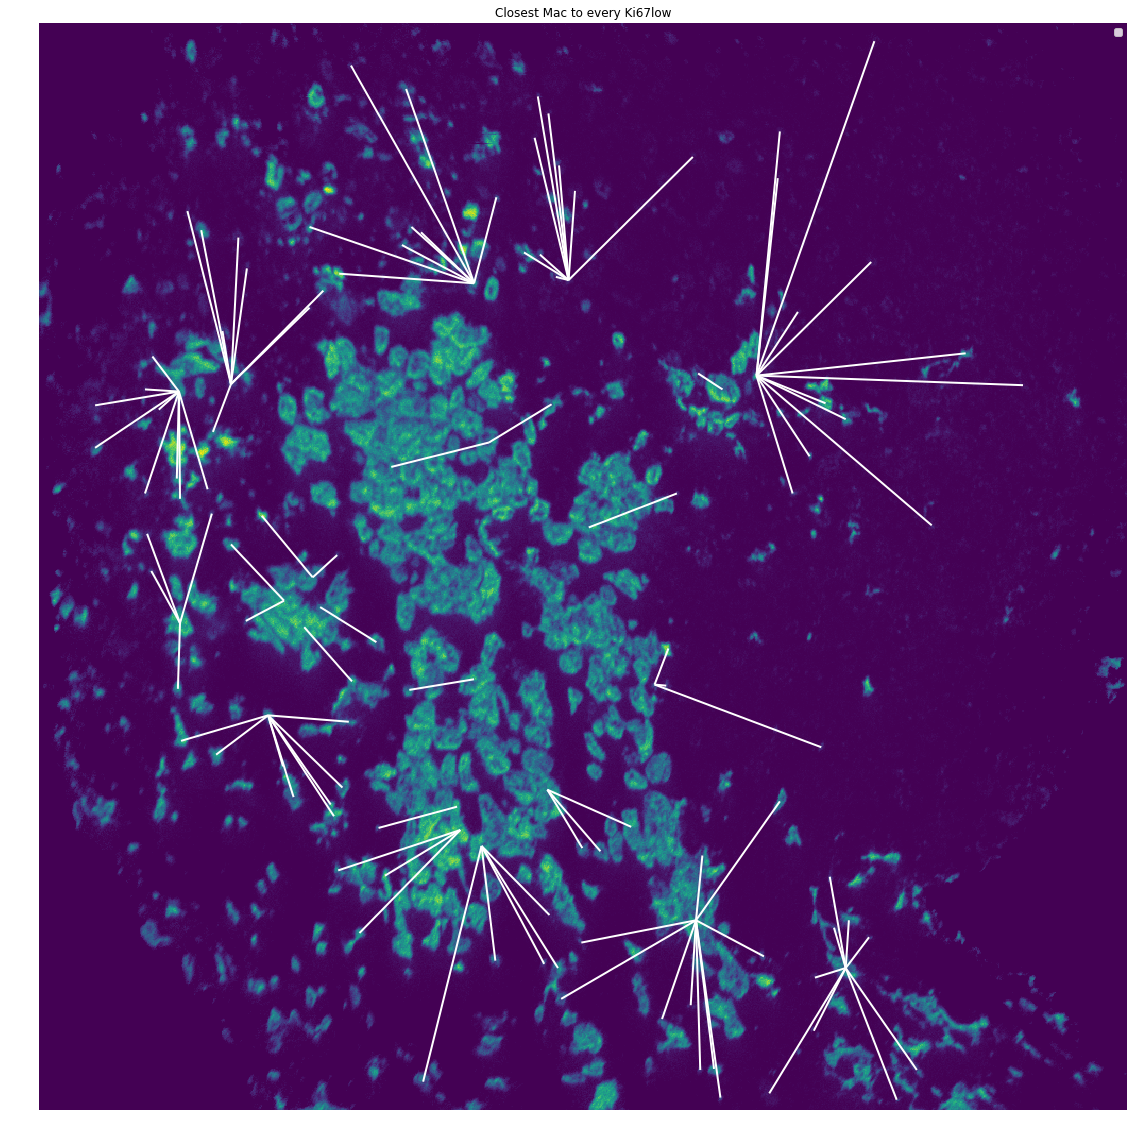

In [120]:
for fov in np.unique(all_data['fov']):
    
    data = all_data[all_data['fov']==fov]
    idx2, d = find_closest(data, dist_mats[fov].values, [cell_type2])
    
    idx1 = data['cell_type'] == cell_type1
    x1 = data.loc[idx1]['centroid-0'].values
    y1 = data.loc[idx1]['centroid-1'].values
    
    x2 = data.loc[idx2]['centroid-0'].values
    y2 = data.loc[idx2]['centroid-1'].values
    pair_idx = idx2[idx1]
    
    lines = [[(y2[val], x2[val]), (y1[i], x1[i])] for i,val in enumerate(pair_idx)]
    
    f, ax = plt.subplots()
    f.set_figheight(20)
    f.set_figwidth(20)
    plt.imshow(data_xr[0,:,:,0].values)
    #plt.scatter(y1,x1,s=20,c='r',label=cell_type1)
    #plt.scatter(y2,x2,s=20,c='w',label=cell_type2)
    
    lc = mc.LineCollection( lines, colors='w',linewidths=2)
    ax.add_collection(lc)
    ax.axis('off')
    ax.set_title('Closest ' + cell_type1 + ' to every ' + cell_type2)
    ax.legend()

In [116]:
plt.imshow(s)

NameError: name 's' is not defined

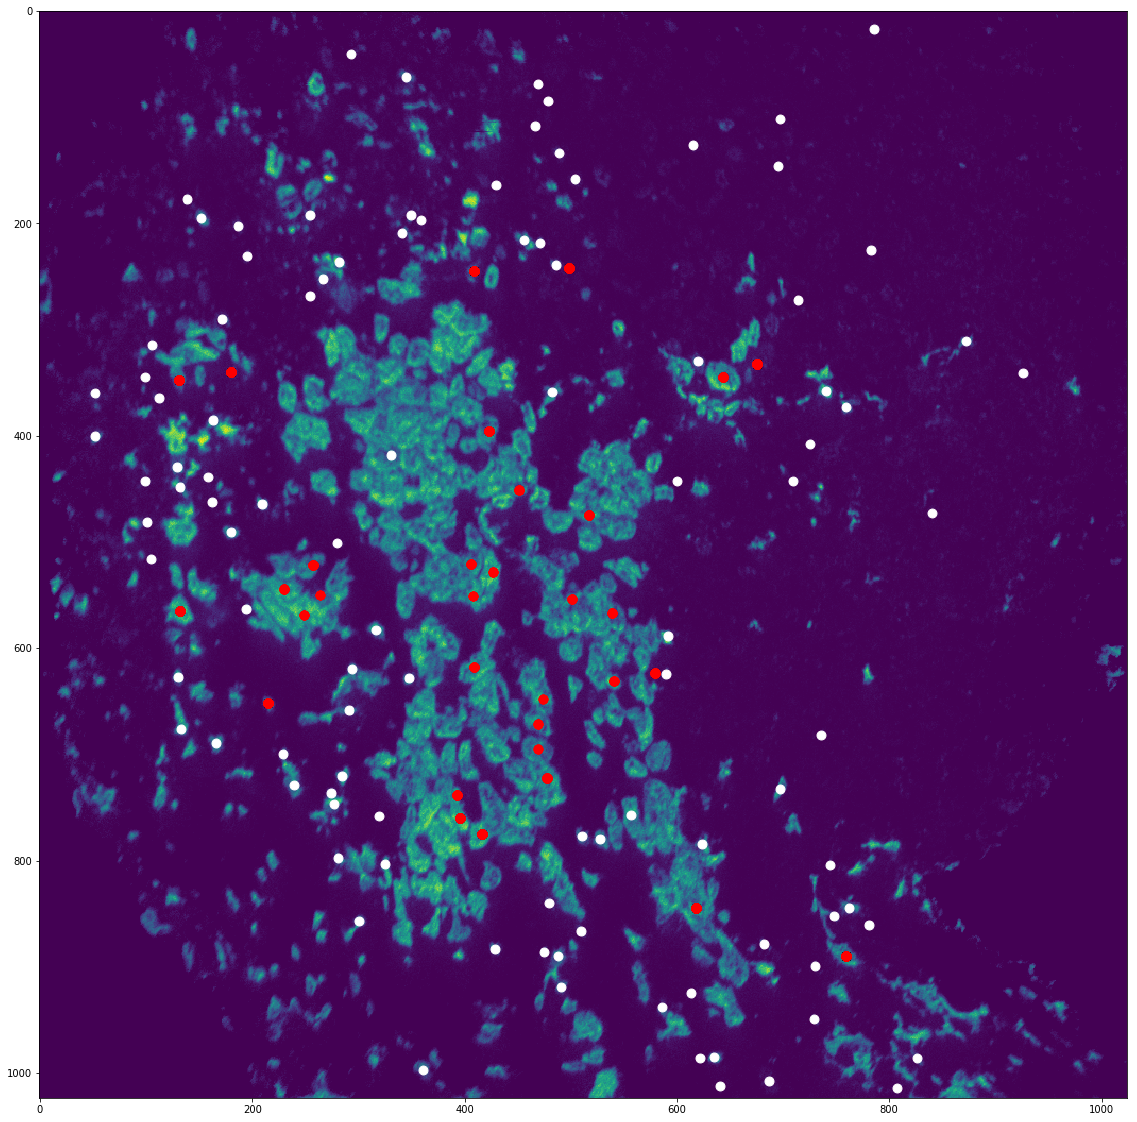

In [104]:
data_xr

<xarray.DataArray (fovs: 1, rows: 1024, cols: 1024, channels: 2)>
array([[[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
...
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]]], dtype=float32)
Coordinates:
  * fovs      (fovs) <U4 'fov2'
  * rows      (rows) int64 0 1 2 3 4 5 6 ... 1017 1018 1019 1020 1021 1022 1023
  * cols      (cols) int64 0 1 2 3 4 5 6 ... 1017 1018 1019 1020 1021 1022 1023
  * channels  (channels) <U5 'dsDNA' 'CD45'